
## Power Limit Embedded Test Script
Use the python bindings to validate embedded code

Copyright 2019 - Charles Vorbach

Released under [GNU General Public License v3.0](https://www.gnu.org/licenses/gpl-3.0.en.html)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
    
import math
    
%matplotlib notebook

In [11]:

import ctypes

lib = ctypes.cdll.LoadLibrary("embedded/build/libeffmap.so")

class EfficiencyMap:
    def __init__(self):
        lib.estimate_power_.argtypes = [ctypes.c_float, ctypes.c_float]
        lib.estimate_power_.restype  = ctypes.c_float
    
        lib.estimate_eff_.argtypes = [ctypes.c_float, ctypes.c_float]
        lib.estimate_eff_.restype  = ctypes.c_float
        
        lib.estimate_torque_limit_.argtypes = [ctypes.c_float, ctypes.c_float, ctypes.c_int, ctypes.c_float]
        lib.estimate_torque_limit_.restype  = ctypes.c_float
        
        lib.get_point_.argtypes = [ctypes.c_int, ctypes.c_int]
        lib.get_point_.restype  = ctypes.c_float

    def estimate_power(self, torque, speed):
        return lib.estimate_power_(torque, speed)

    def estimate_eff(self, torque, speed):
        return lib.estimate_eff_(torque, speed)
    
    def estimate_torque_limit(self, POWER_LIMIT, MAX_TORQUE, STEPS, speed):
        return lib.estimate_torque_limit_(POWER_LIMIT, MAX_TORQUE, STEPS, speed)

efficiency_map = EfficiencyMap()

<IPython.core.display.Javascript object>


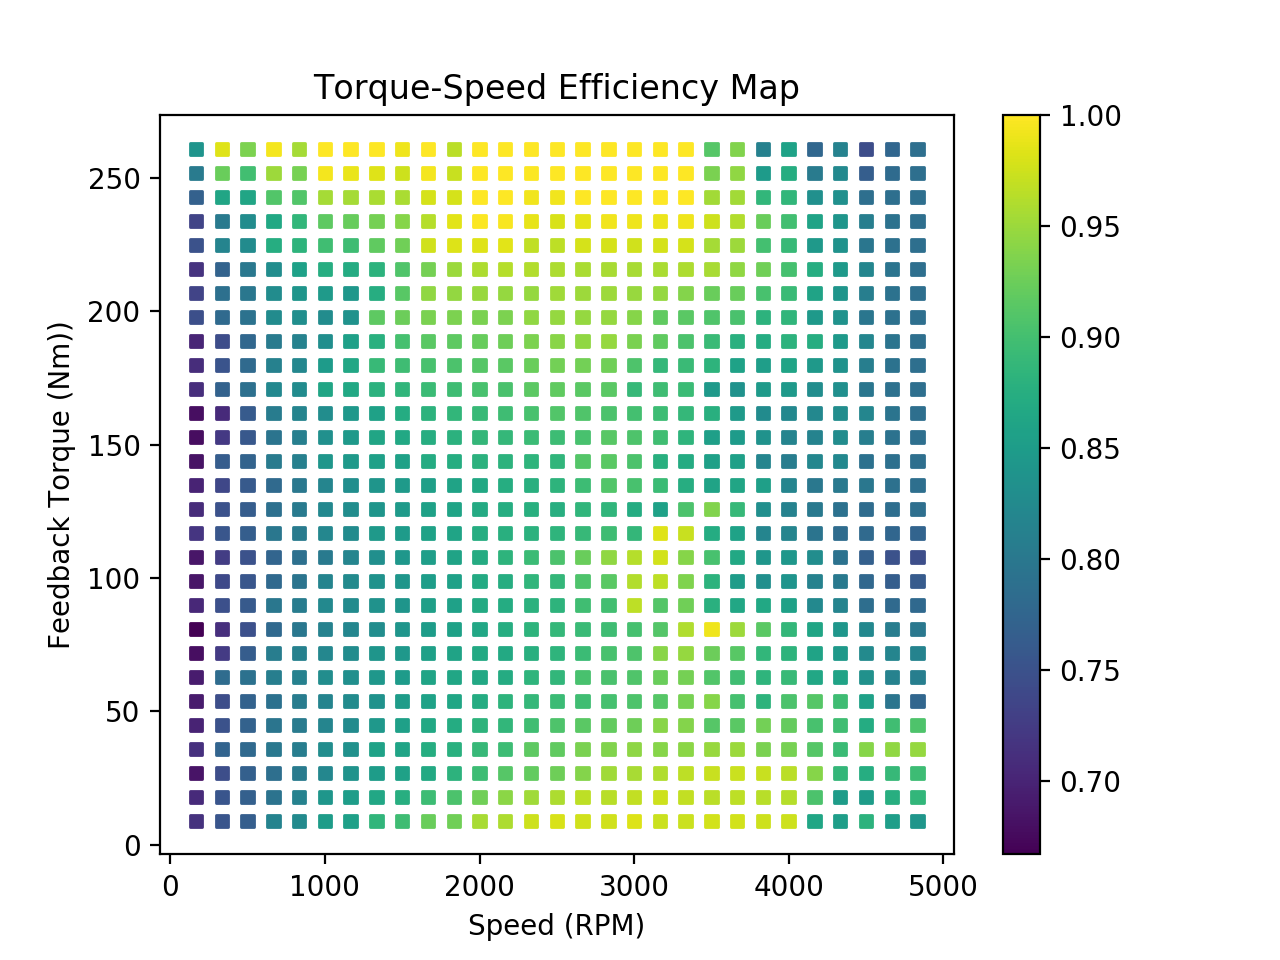

In [12]:
import numpy as np
import matplotlib.pyplot as plt 

BUCKETS = 30
MAX_TORQUE = 270
MAX_SPEED = 5000

TORQUE_STEP = MAX_TORQUE / (BUCKETS)
SPEED_STEP = MAX_SPEED / (BUCKETS)

speeds  = [ SPEED_STEP * i for i in range(1, BUCKETS)]
torques = [TORQUE_STEP * i for i in range(1, BUCKETS)] 

vv, tt = np.meshgrid(speeds, torques)

eff_map = np.zeros((len(speeds), len(torques)))
eff_map[:, :] = np.nan

for i,t in enumerate(torques):
    for j,v in enumerate(speeds):

        eff_map[i, j]  = efficiency_map.estimate_eff(t, v)

fig = plt.figure()
ax = fig.add_subplot(111)

pos = ax.scatter(vv, tt, c=eff_map, s=20, marker='s')

fig.colorbar(pos, ax=ax)

plt.title('Torque-Speed Efficiency Map')
plt.xlabel('Speed (RPM)')
plt.ylabel('Feedback Torque (Nm))')

plt.show()


In [13]:
data = np.load('example-log.npz')

for k in data:
    pass
    print(k)

UNITS
critical__SetLVChannel
control__RMSModulationIndxFluxWeakeningInfo
control__RMSTorqueTimerInfo
control__RMSFaultCodes
critical__CurrentSensor_Power
control__RMSFluxInfo
control__RMSVoltage
control__RMSMotorPositionInfo
control__RMSTemperature
sensor__RadiatorTemperature
critical__CellVoltageRange
sensor__AccelPedals
sensor__SBG_EKF_Velocity
sensor__FlowSensor
sensor__BrakePressureSensor
critical__CurrentSensor_Current
critical__VCUDashInfo
control__RMSParameterCmd
critical__RMSTemps
critical__BamocarTemps
critical__VCUState
sensor__SBG_IMU_DeltaVelocity
sensor__SBG_IMU_DeltaAngle
sensor__SBG_EKF_Position
control__RMSCmd
critical__CurrentSensor_Voltage1
critical__CurrentSensor_Voltage2
critical__CurrentSensor_Voltage3
critical__BMSHeartbeat
critical__CellTemperatureRange
sensor__SBG_EKF_Euler
sensor__SBG_EKF_Velocity_ACC
sensor__SBG_LOG_UTC
sensor__SBG_EKF_Orientation_ACC
sensor__SBG_EKF_Position_ACC
critical__DashRequest
critical__Controls_Settings1
critical__Controls_Settings2
c

In [14]:

# Sorts series with out-of-order timestamps
def clean_series(times, vals):
    
    # Make everything a float
    times = np.float64(times)
    vals  = np.float64(vals) 
    
    sorted_perm = times.argsort() # Time in increasing order
    
    times = times[sorted_perm]    # Permute to match
    times = times - times[0]      # Start at time zero
    
    vals = vals[sorted_perm]      # Permute to match times
    
    return times, vals            # Note, the passed array's haven't been changed


<IPython.core.display.Javascript object>


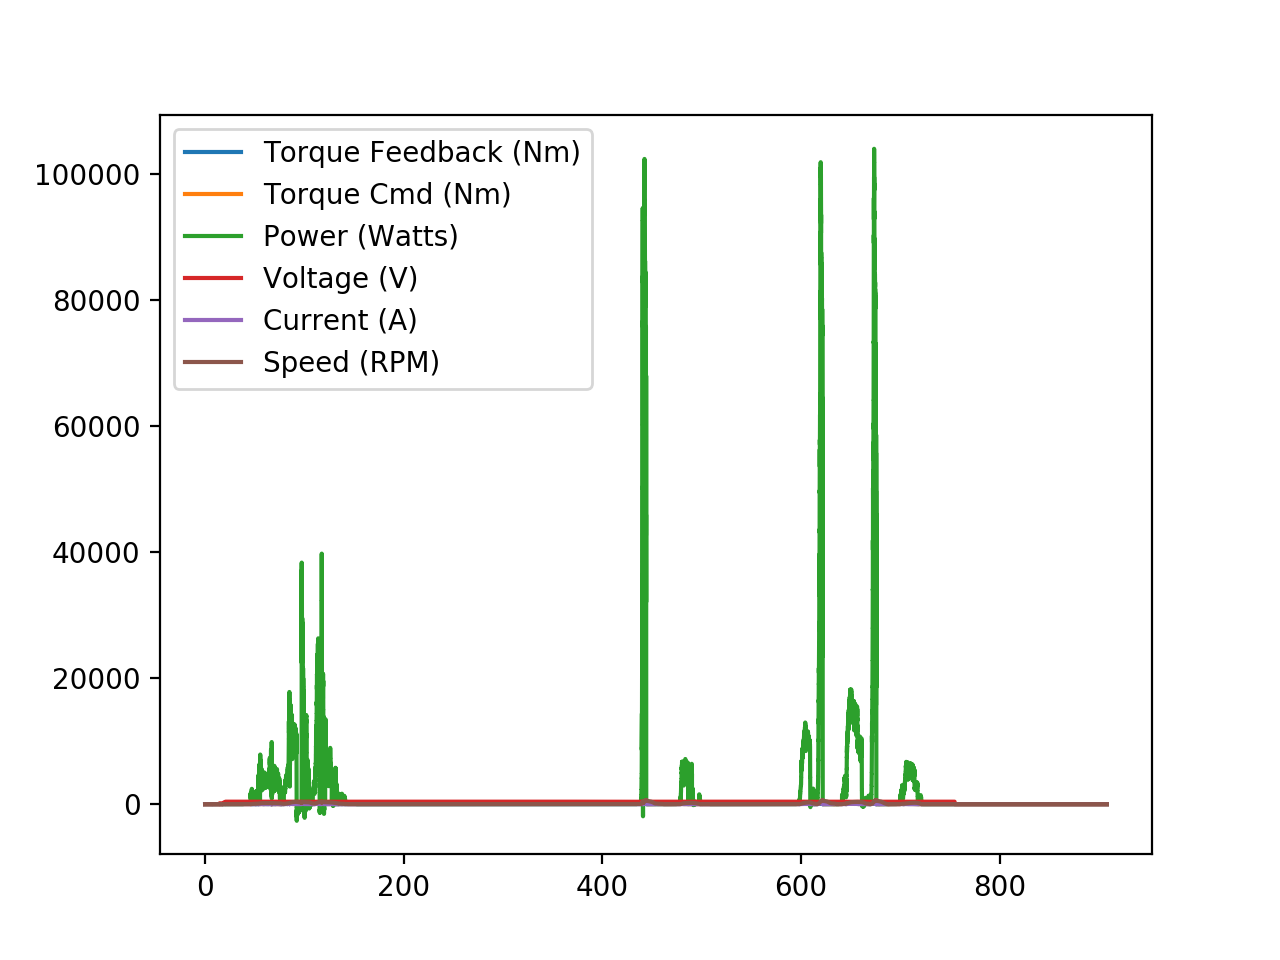

In [15]:

# Name interesting series

# FEEDBACK TORQUE
feedback_times =       data['control__RMSTorqueTimerInfo']['time']
feedback_vals  = 0.1 * data['control__RMSTorqueTimerInfo']['torque_feedback']  # converts dNm -> Nm
feedback_times, feedback_vals = clean_series(feedback_times, feedback_vals)

plt.plot(feedback_times, feedback_vals, label='Torque Feedback (Nm)')

# COMMANDED TORQUE
cmd_times =       data['control__RMSCmd']['time']
cmd_vals  = 0.1 * data['control__RMSCmd']['torque']                            # converts dNm -> Nm
cmd_times, cmd_vals = clean_series(cmd_times, cmd_vals)

plt.plot(cmd_times, cmd_vals, label='Torque Cmd (Nm)')

# POWER 
pwr_times = data['critical__CurrentSensor_Power']['time']
pwr_vals  = data['critical__CurrentSensor_Power']['result']                    # watts
pwr_times, pwr_vals = clean_series(pwr_times, pwr_vals)

plt.plot(pwr_times, pwr_vals, label='Power (Watts)')

# VOLTAGE
volt_times =         data['critical__CurrentSensor_Voltage1']['time']
volt_vals  = 0.001 * data['critical__CurrentSensor_Voltage1']['result']       # converts mV -> V 
volt_times, volt_vals = clean_series(volt_times, volt_vals)

plt.plot(volt_times, volt_vals, label='Voltage (V)')

# CURRENT
curr_times =         data['critical__CurrentSensor_Current']['time']          
curr_vals  = 0.001 * data['critical__CurrentSensor_Current']['result']        # converts mA -> A
curr_times, curr_vals = clean_series(curr_times, curr_vals)

plt.plot(curr_times, curr_vals, label='Current (A)')

# RESOLVER
resolver_times = data['control__RMSMotorPositionInfo']['time']
resolver_vals =  data['control__RMSMotorPositionInfo']['motor_speed'] * math.pi / 30  # converts RPM -> rad/s
resolver_times, resolver_vals = clean_series(resolver_times, resolver_vals)

plt.plot(resolver_times, resolver_vals, label='Speed (RPM)')

plt.legend()


In [16]:

# Interpolate to get a single time vector

time = pwr_times

interp_feedback = np.interp(time, feedback_times, feedback_vals)
interp_cmd      = np.interp(time, cmd_times, cmd_vals)
interp_pwr      = np.interp(time, pwr_times, pwr_vals)
interp_volt     = np.interp(time, volt_times, volt_vals)
interp_curr     = np.interp(time, curr_times, curr_vals)
interp_resolver = np.interp(time, resolver_times, resolver_vals)

# Plot if you like

# plt.plot(time, interp_feedback, '.', label='Feedback')
# plt.plot(time, interp_cmd,      '.', label='Command')
# plt.plot(time, interp_pwr,      '.', label='Power')
# plt.plot(time, interp_volt,     '.', label='Voltage')
# plt.plot(time, interp_curr,     '.', label='Current')
# plt.plot(time, interp_resolver, '.', label='Resolver')
# plt.legend()


In [17]:

# The current sensor does 0th order interpolation between 33 hertz updates
# The voltage and current have been linearly interpolated and so are less laggy

computed_pwr = interp_volt * interp_curr
power = computed_pwr                        # Use this power

# Plot if you like

# plt.plot(t, computed_pwr, '.', label='Voltage*Current (After Interpolation)')
# plt.plot(t, power, '.',   label='Power Message')
# plt.legend()


In [18]:

# Compute power prediction using embedded code

power_predict = np.array([efficiency_map.estimate_power(t,v) for t,v in zip(interp_feedback, interp_resolver)])


<IPython.core.display.Javascript object>


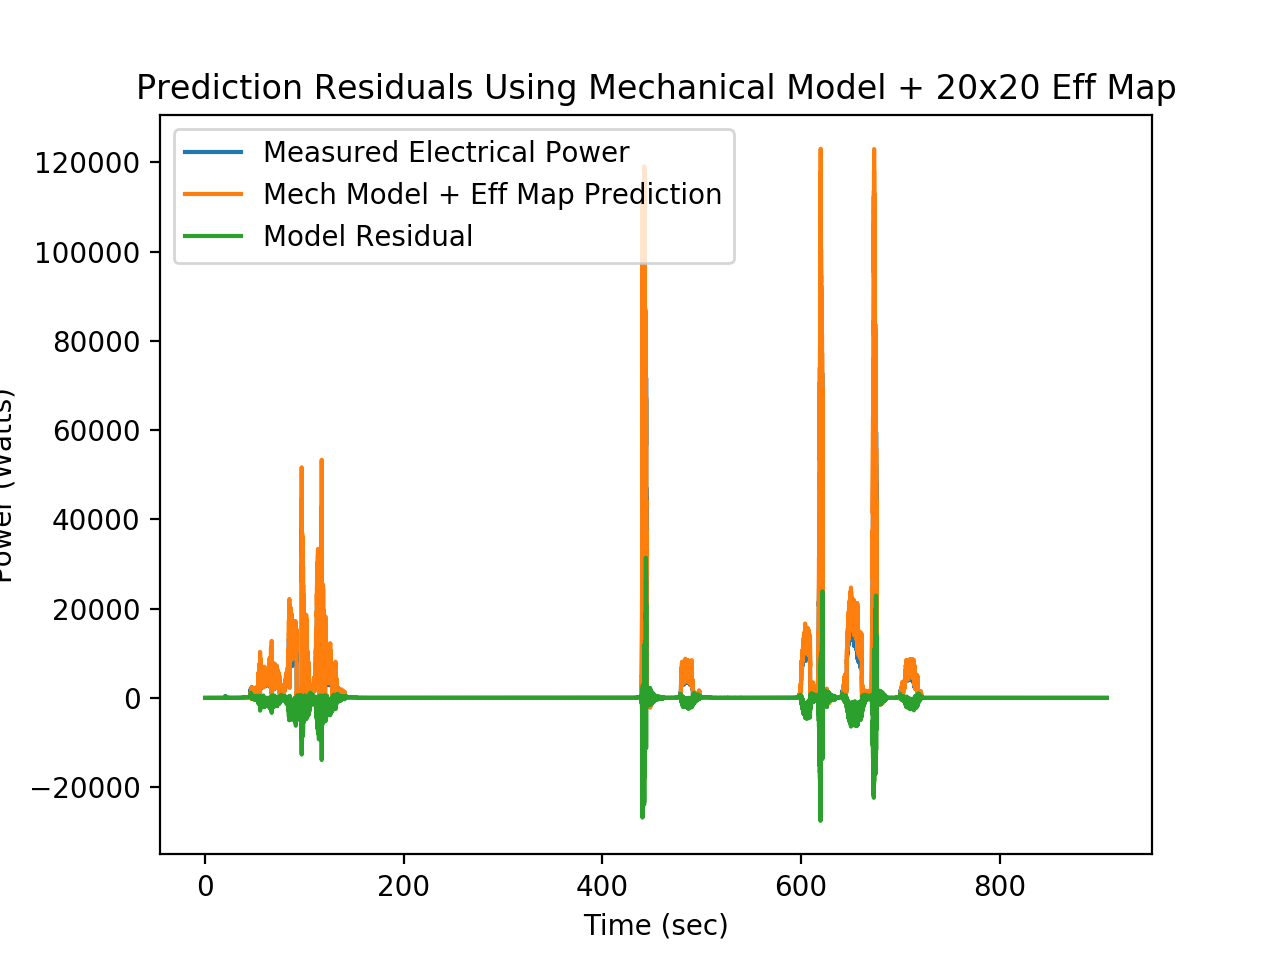

Text(0, 0.5, 'Power (Watts)')

In [19]:

# Plot prediction and residual

residual = power - power_predict

plt.plot(time, power, label='Measured Electrical Power')
plt.plot(time, power_predict, label='Mech Model + Eff Map Prediction')
plt.plot(time, residual, label='Model Residual')

plt.legend()

plt.title('Prediction Residuals Using Mechanical Model + 20x20 Eff Map')
plt.xlabel('Time (sec)')
plt.ylabel('Power (Watts)')
         

In [22]:

# Compute torque limit

POWER_LIMIT = 80000
MAX_TORQUE  = 300
STEPS       = 100

torque_limit = np.array([efficiency_map.estimate_torque_limit(POWER_LIMIT, MAX_TORQUE, STEPS, s) for s in interp_resolver])


In [23]:

# Estimate power using limited torque and map efficiency

limited_torque = np.minimum(torque_limit, interp_feedback)

limited_power_predict = np.array([efficiency_map.estimate_power(t,v) for t,v in zip(limited_torque, interp_resolver)])

<IPython.core.display.Javascript object>


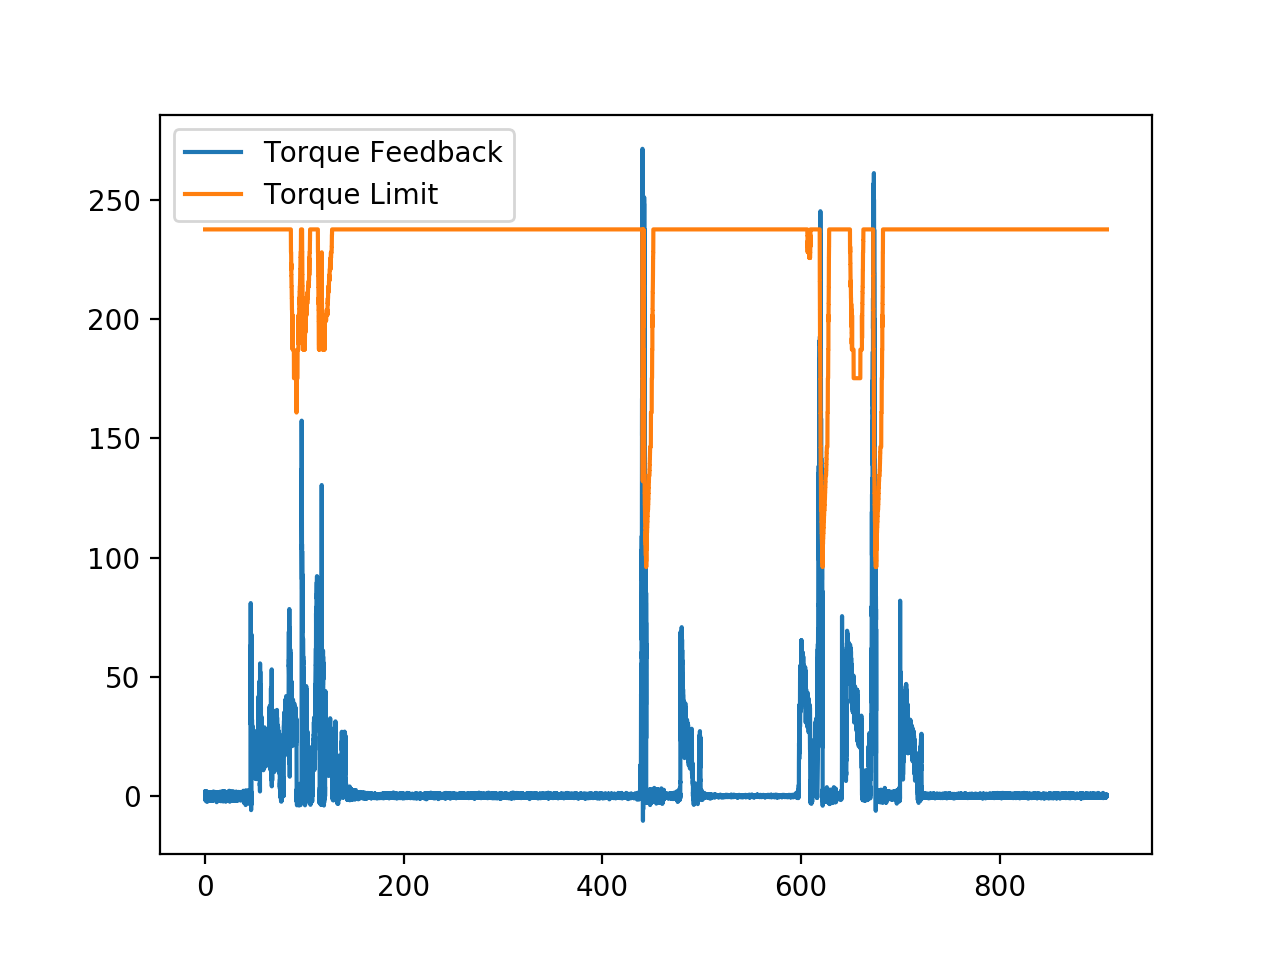

In [29]:

# Plot limited and actual torque

plt.plot(time, interp_feedback, label="Torque Feedback")
# plt.plot(time, interp_cmd,      label="Torque Command")
plt.plot(time, torque_limit,    label="Torque Limit")

plt.legend()


<IPython.core.display.Javascript object>


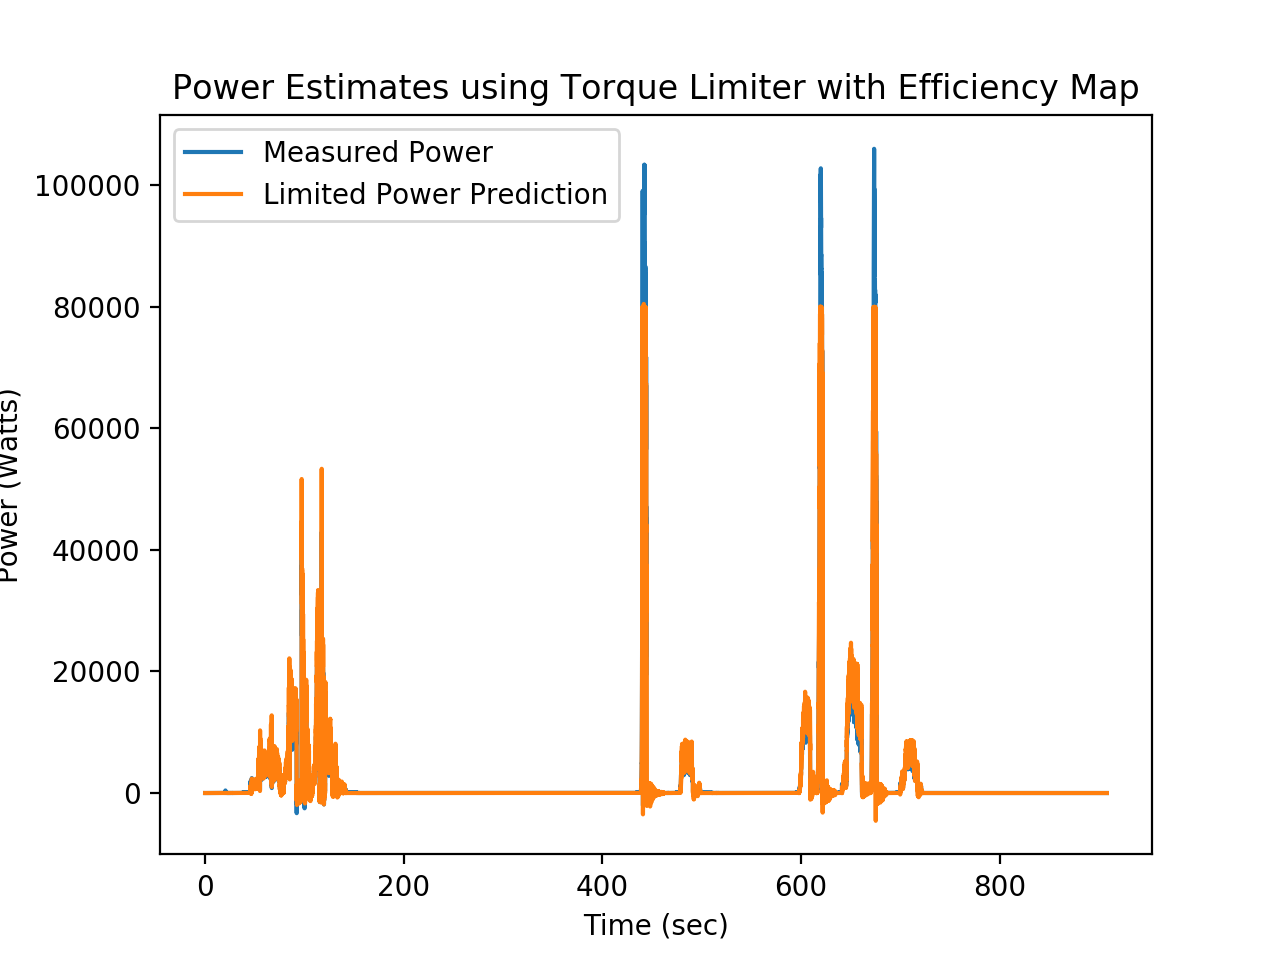

Text(0, 0.5, 'Power (Watts)')

In [30]:

# Plot estimated power

plt.plot(time, power, label="Measured Power")
plt.plot(time, limited_power_predict, label="Limited Power Prediction")

plt.legend()

plt.title('Power Estimates using Torque Limiter with Efficiency Map')
plt.xlabel('Time (sec)')
plt.ylabel('Power (Watts)')
